# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, SeparableConv1D, MaxPooling1D

Using TensorFlow backend.


# Function for Reading Data

In [2]:
def read_data(suffix=''):
    
    x_train_df = pd.read_csv('x_train' + suffix + '.csv', index_col=0)
    x_test_df = pd.read_csv('x_test' + suffix + '.csv', index_col=0)
    y_train_series = pd.read_csv('y_train' + suffix + '.csv', index_col=0, header=None)
    y_test_series = pd.read_csv('y_test' + suffix + '.csv', index_col=0, header=None)

    # Just grab the values for training.
    x_train = x_train_df.values
    x_test = x_test_df.values
    y_train = y_train_series.values
    y_test = y_test_series.values
    print('Data loaded.')
    
    return x_train, y_train, x_test, y_test

# Function to Create ANN, Define Early Stopping

In [3]:
def init_ann(x_shape):
    # This is just a silly simple ANN. Neurons per layer were selected with barely
    # any thought (except that people tend to use numbers which are powers of 2).
    ann = Sequential()
    ann.add(Dense(x_shape[1], input_dim=x_shape[1], activation='relu'))
    ann.add(Dense(256, activation='relu'))
    ann.add(Dropout(0.25))
    ann.add(Dense(128, activation='relu'))
    ann.add(Dropout(0.25))
    ann.add(Dense(64, activation='relu'))
    ann.add(Dropout(0.25))
    ann.add(Dense(1))

    ann.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['mse'])

    ann.summary()
    
    return ann

# Create early stopping callback.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Function for Training and Prediction

In [4]:
def train_predict(suffix):
    x_train, y_train, x_test, y_test = read_data(suffix=suffix)

    ann = init_ann(x_shape=x_train.shape)

    # Perform the fit. We'll shuffle the data after each epoch, and withhold 
    # 20% of the data for validation.
    ann.fit(x_train, y_train, epochs=100, shuffle=True,
            validation_split=0.2, callbacks=[early_stop])
    
    y_pred = ann.predict(x_test)
    
    return y_pred, x_test, y_test
    
def plot(y_p, x_t, y_t):
    
    plt.scatter(y_t, y_p)
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('ANN Predicted vs. Actual')
    plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()])
#     plt.show()
#     return plt.gca()

# ANN with Standard Scaling

In [5]:
y_pred_s, x_test_s, y_test_s = train_predict(suffix='')

Data loaded.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4864      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 

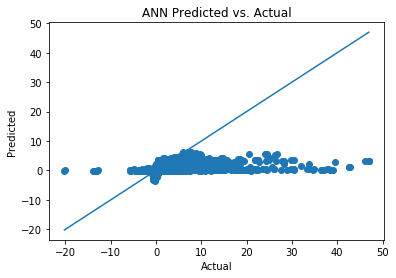

In [6]:
plot(y_p=y_pred_s, x_t=x_test_s, y_t=y_test_s)

# ANN with Min/Max Scaling

In [7]:
y_pred_mm, x_test_mm, y_test_mm = train_predict(suffix='_mm')

Data loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_7 (Dense)              (None, 256)               4864      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0       

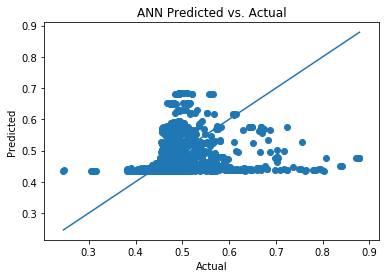

In [8]:
plot(y_p=y_pred_mm, x_t=x_test_mm, y_t=y_test_mm)

# ANN with Both Standard and Min/Max Scaling

In [9]:
y_pred_both, x_test_both, y_test_both = train_predict(suffix='_both')

Data loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4864      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0       

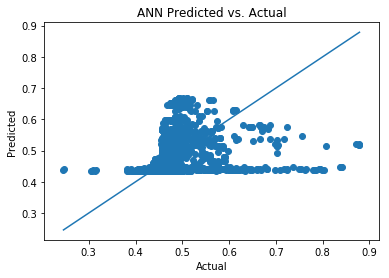

In [10]:
plot(y_p=y_pred_both, x_t=x_test_both, y_t=y_test_both)

# Metrics, Plotting, etc.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.externals import joblib

# Load scaler objects which data_prep wrote.
standard_y = joblib.load('standard_scaler_y.save')
# standard_x = joblib.load('standard_scaler_x.save')
minmax_y = joblib.load('min_max_scaler_y.save')
# minmax_x = joblib.load('min_max_scaler_x.save')
both_y = joblib.load('both_scaler_y.save')
# both_x = joblib.load('both_scaler_x.save')

In [30]:
def eval_metrics(y_true, y_pred, scaler, scaler2=None):
    y_true_scaled = scaler.inverse_transform(y_true)
    y_pred_scaled = scaler.inverse_transform(y_pred)
    
    if scaler2 is not None:
        y_true_scaled = scaler2.inverse_transform(y_true_scaled)
        y_pred_scaled = scaler2.inverse_transform(y_pred_scaled)
    
    mae = mean_absolute_error(y_true=y_true_scaled,
                              y_pred=y_pred_scaled)
    mse = mean_squared_error(y_true=y_true_scaled,
                             y_pred=y_pred_scaled)
    r2 = r2_score(y_true=y_true_scaled,
                  y_pred=y_pred_scaled)
    
    print('MAE: {:.4f}'.format(mae))
    print('MSE: {:.4f}'.format(mse))
    print('R2:  {:.4f}'.format(r2))
    
    plt.plot(np.arange(0, len(y_true_scaled)), y_true_scaled, y_pred_scaled)
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Time (5-minute intervals for 2018)')
    plt.ylabel('Price (USD)')
    return y_true_scaled, y_pred_scaled

## Standard Scaler

MAE: 14.6868
MSE: 2456.6608
R2:  0.2601


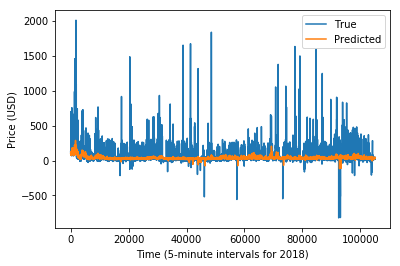

In [31]:
y_true_standard, y_pred_standard = \
    eval_metrics(y_true=y_test_s, y_pred=y_pred_s, scaler=standard_y)
# plt.show()

## Min/Max Scaler

MAE: 15.4770
MSE: 2867.0050
R2:  0.1366


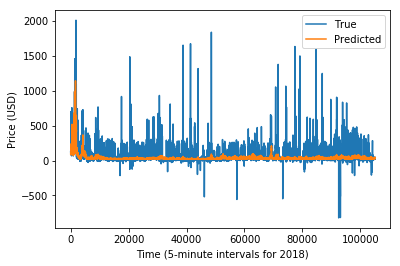

In [32]:
y_true_minmax, y_pred_minmax = \
    eval_metrics(y_true=y_test_mm, y_pred=y_pred_mm, scaler=minmax_y)

## Both Scaling

MAE: 980006506.4208
MSE: 960516006151704576.0000
R2:  -289272482418988.1250


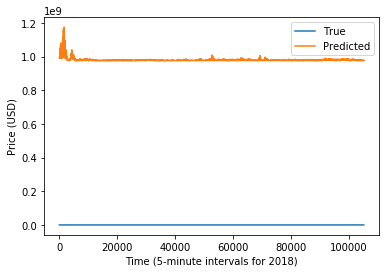

In [33]:
# TODO: Why is this broken?
y_true_both, y_pred_both = \
    eval_metrics(y_true=y_test_both, y_pred=y_pred_both, scaler=both_y, scaler2=standard_y)